# Quantized Estimators

A specific family of transformations that can facilitate the task of estimating mutual information includes functions that map continuous variable into a finite discrete set of possible outcomes.
We refer to such functions $Q$ as *quantization function* and use $\bar{x}$ and $\bar{y}$ to indicate the *quantized* versions of $x$ and $y$ respectively.
$$
Q_x(x) =: \bar x \in [1, \dots, K_x],  Q_y(y) =: \bar y \in [1, \dots, K_y],
$$
in which $K_x$ and $K_y$ indicate the side of the domain of $\bar x$ and $\bar y$ respectively.





In [14]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch_mist.data.multimixture import MultivariateCorrelatedNormalMixture
from torch_mist.utils import train_mi_estimator
import pandas as pd

sns.set_style('whitegrid')
IMG_SIZE=3

train_parameters = dict(
    max_epochs=10,
    batch_size= 128,
    verbose=True,
    valid_percentage=0,
    lr_annealing=True,
)

# Definition of the distribution
p_XY = MultivariateCorrelatedNormalMixture(n_dim=1)

true_mi = p_XY.mutual_information('x','y')

# Generate 100000 samples
samples = p_XY.sample([100000])
all_x = samples['x']
all_y = samples['y']
x_dim=y_dim=1

for i in range(100):
    samples = p_XY.sample([100000])

p_Y_given_X = p_XY.conditional('x')
p_Y = p_XY.marginal('y')


A simple quantization strategy for 1D data can be defined by creating uniform spaced bins:
$$
 \bar{x} := Q(x) = \sum_{i=1}^{K_x} [x>t_i],
$$ 
in which $t_1,\dots, t_K$ represents a list of equidistant thresholds

In [2]:
from torch_mist.quantization import FixedQuantization

n_bins = 16

Q_functions = {
    'Uniform': FixedQuantization(
        input_dim=x_dim,
        thresholds=torch.linspace(-3,3,n_bins)
    ),
}

This strategy scales poorly for high dimensional data, since the total number of bins scales as the product of the number of thresholds in each dimension. 

Another simple strategy to consider could involve the use of a clustering algorithm to map each data-point into a discrete class label.

In [3]:
from torch_mist.quantization import kmeans_quantization

Q_functions ['KMeans'] = kmeans_quantization(
    data=samples['x'],
    n_bins=n_bins
)


Other modern approach involve training Vector Quantized Variational Autoencoder (VQVAE) to learn a quantization scheme. The `torch_mist` package includes utilities to instantiate and train vector quantization schemes.

In [4]:
from torch_mist.quantization import vqvae_quantization

Q_functions ['VQVAE'] = vqvae_quantization(
    input_dim=x_dim,
    data=samples['x'],
    n_bins=n_bins,
    quantization_dim=32,
    hidden_dims=[64, 32],
    batch_size=128,
    max_epochs=5,
)

We can visualize the intervals corresponding to the quantization schemes. Note that KMeans and VQVAE adaptively split high density regions into bins with similar marginal probabilities, this results into a more efficient encoding that is able to preserve more information about the original data.

Text(0, 0.5, '$p(\\bar{x})$')

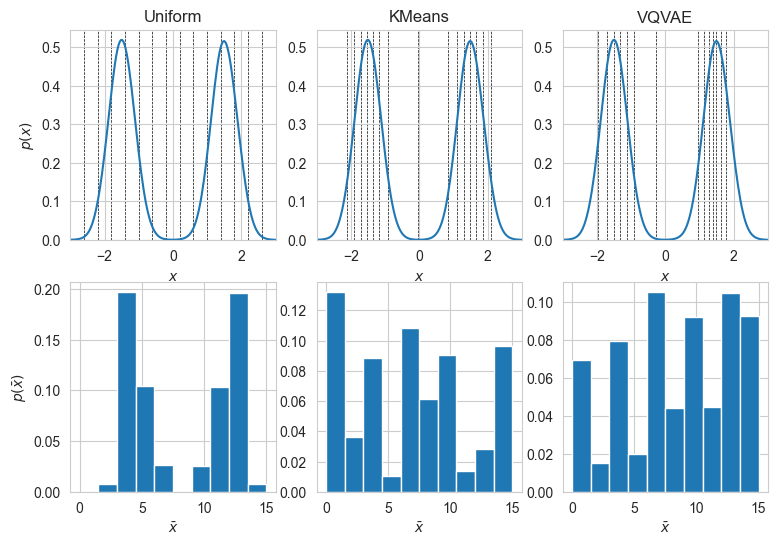

In [5]:
f, ax = plt.subplots(2, len(Q_functions), figsize=(len(Q_functions)*IMG_SIZE, IMG_SIZE*2))

x  = torch.linspace(-3,3,1000).reshape(-1,1)
for i, (name, Q) in enumerate(Q_functions.items()):
    
    boundary = Q(x)[1:]-Q(x)[:-1]
    for b in x[:-1,0][boundary!=0]:
        ax[0,i].axvline(x=b, ls='--', color='k', zorder=-4, linewidth=0.5 )
    sns.distplot(samples['x'], ax=ax[0,i], hist=False)
    ax[0,i].set_xlim(-3,3)
    ax[0,i].set_title(name)
    ax[1,i].hist(Q(samples['x']), density=True)
    ax[0,i].set_xlabel('$x$')    
    ax[0,i].set_ylabel('')
    ax[1,i].set_xlabel('$\\bar{x}$')

ax[0,0].set_ylabel('$p(x)$')
ax[1,0].set_ylabel('$p(\\bar{x})$')

### Binned Mutual Information Estimation
Modeling flexible categorical distribution on discrete domains is generally much easier than parametrizing flexible continuous distributions.
Once the variables $x$ and $y$ are quantized, one can estimate mutual information by considering the difference of entropies of the corresponding categorical distributions.
$$
I(\bar{x};\bar{y}) = H(\bar{x}) + H(\bar{y}) - H(\bar{x},\bar{y}),
$$
which can be directly computed as,
$$
I(\bar{x};\bar{y}) = \sum_{i=1}^{K_x}\sum_{j=1}^{K_y} \theta_{ij} \log \frac{\theta_{ij}}{\left(\sum_{k=1}^{K_y} \theta_{ik}\right)\left(\sum_{k=1}^{K_x} \theta_{kj}\right)}.
$$
 The probabilities of all the possible outcomes for $\bar x$ and $\bar y$ can be represented in a $[K_x \times K_y]$ matrix $\theta$, in which each entry $\theta_{ij}$ corresponds to a variational estimate $q_\theta(\bar{x}=i, \bar{y}=j)$.

The entries of $\theta$ can be learned using maximum likelihood, analogously to the generative estimator $GM$, which requires fitting a variational joint distribution $q_\theta(x,y)$. Here the main difference lies in the fact that we don't need to model the marginals explicitly since they can be obtained by directly marginalizing $q_\theta(\bar{x},\bar{y})$:
$$
 q_\theta(\bar{x}=i) = \sum_{j=1}^{K_y} q_\theta(\bar{x}=i, \bar{y}=j) =  \sum_{j=1}^{K_y} \theta_{ij},\ \ \  q_\theta(\bar{y}=j) = \sum_{i=1}^{K_x} q_\theta(\bar{x}=i, \bar{y}=j) =  \sum_{i=1}^{K_x} \theta_{ij}
$$
We refer to this estimator as `BinnedMIEstimator` and, since the distribution is symmetric in $x$ and $y$, in this example we use the same quantization funtion $Q$ to define $\bar x$ and $\bar y$.


In [6]:
from torch_mist.estimators import BinnedMIEstimator

# Instantiate one estimator for each quantization function
estimators = {
    name: BinnedMIEstimator(
        Q_x=Q,
        Q_y=Q,
        temperature=0.1
    ) for name, Q in Q_functions.items()
}

# Training logs
pd_log = pd.DataFrame()

# Train all the estimators
for name, estimator in estimators.items():
    print(f"Training the Binned MI estimator with the {name} quantization")
    train_log = train_mi_estimator(
        estimator=estimator,
        x=samples['x'], y=samples['y'],
        **train_parameters           
    )
    train_log['quantization'] = name
    pd_log = pd.concat([pd_log, train_log])

Training the Binned MI estimator with the Uniform quantization


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Training the Binned MI estimator with the KMeans quantization


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Training the Binned MI estimator with the VQVAE quantization


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

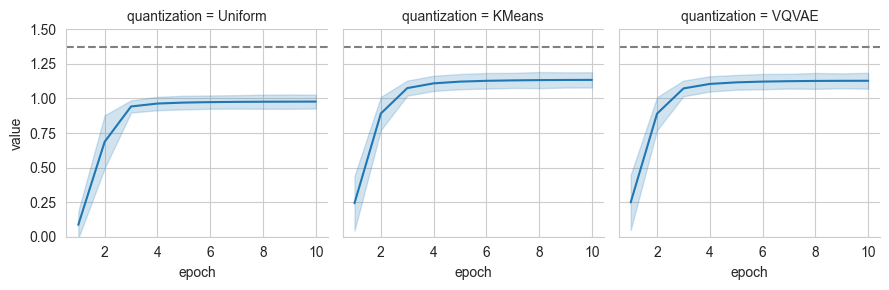

In [8]:
# Plot the estimated values of mutual information over time
grid = sns.FacetGrid(pd_log[pd_log['name']=='mutual_information'], col='quantization', ylim=(0,1.5))
grid.map(sns.lineplot, 'epoch', 'value', errorbar='sd')
grid.refline(y=true_mi)

As expected, under the assumption that $q_\theta(\bar{x}, \bar{y})$ accurately models $p(\bar{x}, \bar{y})$, the binned estimator for $I(\bar{x};\bar{y})$ tends to underestimate the true value of mutual information.

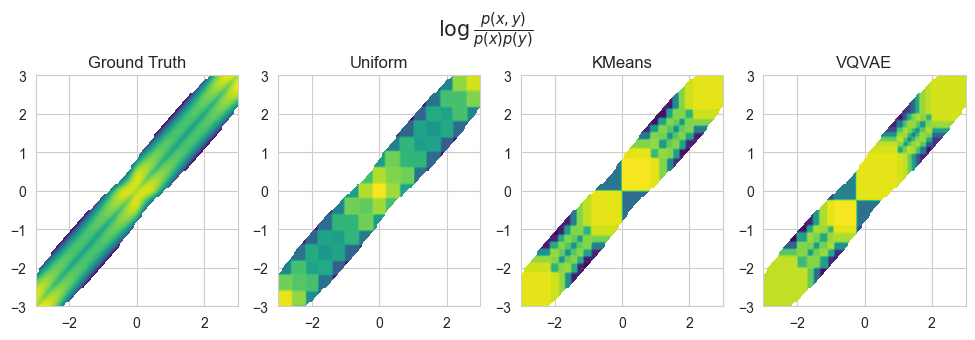

In [9]:
# We create a uniform grid to visualize the log-ratios log p(x,y)/p(x)p(y) implied by the models
res = 100
x_grid = torch.linspace(-3,3,res).view(-1,1,1)
y_grid = torch.linspace(-3,3, res).view(1,-1,1)
X, Y = np.meshgrid(x_grid, y_grid)

# Compute the true log-ratio log p(x,y)p(x)p(y) on the grid
log_marginal = p_XY.marginal('x').log_prob(x=x_grid) +  p_XY.marginal('y').log_prob(y=y_grid)
log_joint = p_XY.log_prob(x=x_grid, y=y_grid)
log_ratio = (log_joint - log_marginal).data.numpy()

# We visualize only the points for which p(x,y) > e^{-20}
mask = (log_joint>-20).data.numpy()

# Plot the true log-ratio
f, ax = plt.subplots(1,len(estimators)+1,figsize=((1+len(estimators))*IMG_SIZE, IMG_SIZE))
f.suptitle("$\\log \\frac{p(x,y)}{p(x)p(y)}$", fontsize=15, y=1.1)
ax[0].contourf(X, Y, log_ratio/mask, cmap='viridis', levels=40)
ax[0].set_title('Ground Truth')

# And log-ratios implied by the different quantization schemes
for i, (name, estimator) in enumerate(estimators.items()):
    unnormalized_ratio = estimator.log_ratio(x_grid.repeat(1,res,1), y_grid.repeat(res,1,1)).data.numpy()
    ax[i+1].contourf(X, Y, unnormalized_ratio/mask, cmap='viridis', levels=40)
    ax[i+1].set_title(name)

Note that the estimations obtained with non-uniform adaptive quantization schemes are closer to the true value of mutual information. This can be also observed by visualized the log-ratios $\log\frac{p(x,y)}{p(x)p(y)}$ modeled by the `BinnedMIEstimator` models.

## Predictive Quantization
Instead of quantizing both variables $x$ and $y$ to simplify the modeling of marginal and joint densities, it is possible to design flexible estimators by quantizing only one of the two variables. This can be done by estimating information as a difference of (conditional) entropies, as in the generative `DoE` estimator:
$$
I(x;y)\ge I(x;\bar{y}) = H(\bar{y}) - H(\bar{y}|x) \approx \mathbb{E}_{p(x,y)}\left[-\log q_\phi(\bar y) + \log q_\theta(\bar{y}|x)\right],
$$
in which both $q_\phi(\bar y)$ and $q_\theta(\bar{y}|x)$ are (conditional) categorical distributions.
$q_\phi(\bar y)$ can be modeled directly by a vector $\phi$ in which $\phi_i = q_\phi(\bar y=i)$, while $q_\theta(\bar y|x)$ can be modeled with a flexible neural network $f_\theta(x)$ that maps each continuous $x$ into the logits for a categorical distribution $q_\theta(\bar y=i|x) = \frac{e^{f_\theta(x)_i}}{\sum_{j=1}^{K_y} e^{f_\theta(x)_j}}$.

We refer to the corresponding mutual information estimator as *Predictive Quantization* (`PQ`).

In [11]:
from torch_mist.estimators import pq

# Training logs
pd_log = pd.DataFrame()

estimators = {
    name: pq(
        Q_y=Q,
        temperature=0.1,
        hidden_dims=[64, 32],
        x_dim=x_dim,
    ) for name, Q in Q_functions.items()
}

# Train all the estimators
for name, estimator in estimators.items():
    print(f"Training the PQ MI estimator with the {name} quantization")
    train_log = train_mi_estimator(
        estimator=estimator,
        x=samples['x'], y=samples['y'],
        **train_parameters           
    )
    train_log['quantization'] = name
    pd_log = pd.concat([pd_log, train_log])

Training the PQ MI estimator with the Uniform quantization


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Training the PQ MI estimator with the KMeans quantization


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Training the PQ MI estimator with the VQVAE quantization


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

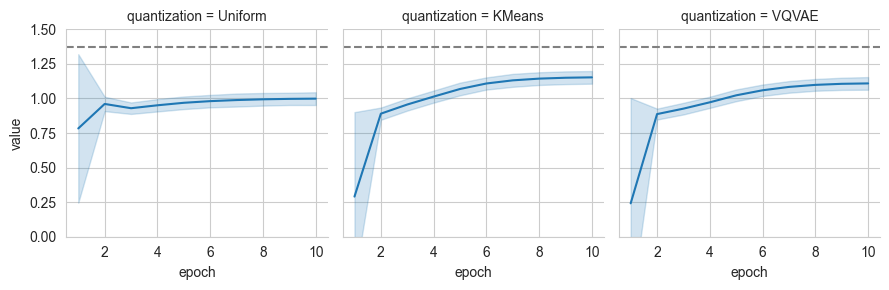

In [12]:
# Plot the estimated values of mutual information over time
grid = sns.FacetGrid(pd_log[pd_log['name']=='mutual_information'], col='quantization', ylim=(0,1.5))
grid.map(sns.lineplot, 'epoch', 'value', errorbar='sd')
grid.refline(y=true_mi)

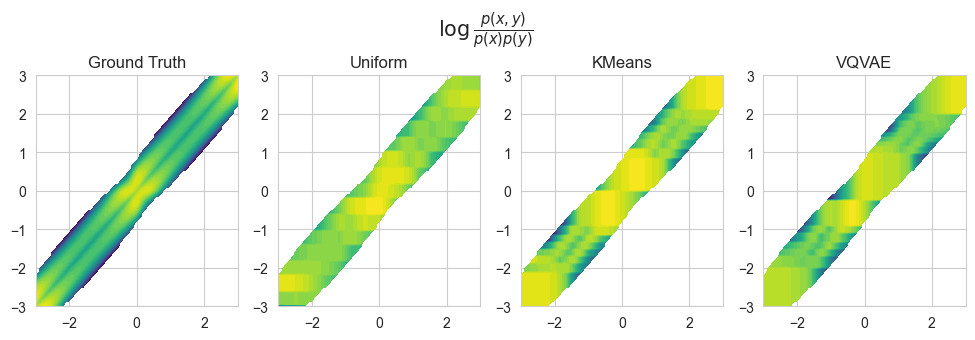

In [13]:
# We create a uniform grid to visualize the functions modeled by the critics
res = 100
x_grid = torch.linspace(-3,3,res).view(1,-1,1)
y_grid = torch.linspace(-3,3, res).view(-1,1,1)
X, Y = np.meshgrid(x_grid, y_grid)

# Compute the true log-ratio log p(x,y)p(x)p(y) on the grid
log_marginal = p_XY.marginal('x').log_prob(x=x_grid) +  p_XY.marginal('y').log_prob(y=y_grid)
log_joint = p_XY.log_prob(x=x_grid, y=y_grid)
# We visualize only the points for which p(x,y) > e^{-20}
mask = (log_joint>-20).data.numpy()
log_ratio = (log_joint - log_marginal).data.numpy()

# Plot the true log-ratio
f, ax = plt.subplots(1,len(estimators)+1,figsize=((1+len(estimators))*IMG_SIZE, IMG_SIZE))
f.suptitle("$\\log \\frac{p(x,y)}{p(x)p(y)}$", fontsize=15, y=1.1)
ax[0].contourf(X, Y, log_ratio/mask, cmap='viridis', levels=40)
ax[0].set_title('Ground Truth')

# And the unnormalized log-ratio modeled by the critics
for i, (name, estimator) in enumerate(estimators.items()):
    unnormalized_ratio = estimator.log_ratio(x_grid.repeat(res,1,1), y_grid.repeat(1,res,1)).data.numpy()
    ax[i+1].contourf(X, Y, unnormalized_ratio/mask, cmap='viridis', levels=40)
    ax[i+1].set_title(name)

Quantizing only one of the two variable results into generally more accurate estimation since $I(\bar x;\bar y)\le I(x;\bar y)$, and the estimates is less affected by the choice of the quantization function. 

Contrarily to the continuous `DoE` estimator, `PQ` does not require the definition of complex and flexible densities on continuous random variables. This usually comes at the cost of a less tight bound since $I(x;\bar y) \le I(x;y)$